# Aqua Modis

---

In [ ]:
import xarray as xr
import glob
import os

# Coordenadas de recorte
lon_min, lon_max = -84.6, -45
lat_min, lat_max = 23, 43

# Lista de archivos
archivos = sorted(glob.glob("*.nc"))
recortes = []

for f in archivos:
    print(f"Procesando {f} ...")
    
    # Abrir con lazy loading
    ds = xr.open_dataset(f, chunks={})
    
    # Detectar si lat/lon están ascendentes o descendentes
    lat_coord = ds.coords['lat']
    lon_coord = ds.coords['lon']
    
    lat_slice = slice(lat_min, lat_max) if lat_coord[0] < lat_coord[-1] else slice(lat_max, lat_min)
    lon_slice = slice(lon_min, lon_max) if lon_coord[0] < lon_coord[-1] else slice(lon_max, lon_min)
    
    # Hacer recorte
    ds_recorte = ds.sel(lat=lat_slice, lon=lon_slice)
    
    # Guardar recorte temporal
    nombre_salida = f"recorte_{os.path.basename(f)}"
    ds_recorte.to_netcdf(nombre_salida)
    recortes.append(nombre_salida)
    
    ds.close()
    print(f"✅ Guardado {nombre_salida}")

print("🧩 Todos los recortes individuales listos.")

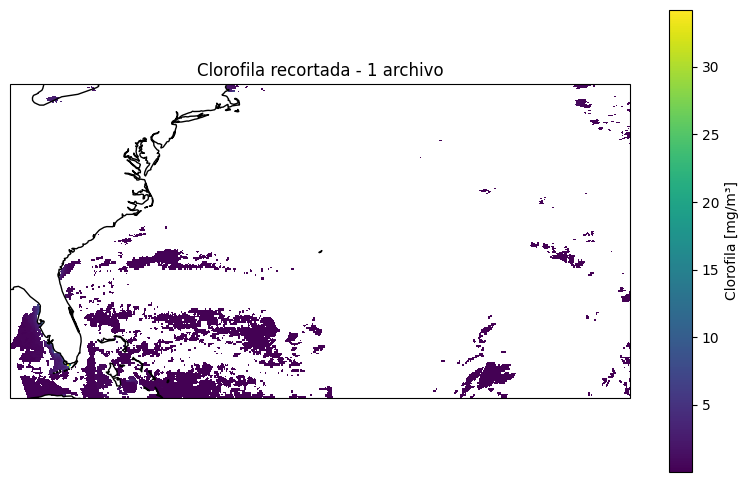

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Abrir el recorte
ds = xr.open_dataset("recorte_AQUA_MODIS.20130101.L3m.DAY.CHL.chlor_a.4km.nc")

# Seleccionar la variable de clorofila
chl = ds['chlor_a']

# Graficar
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
chl.plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Clorofila [mg/m³]'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("Clorofila recortada - 1 archivo")
plt.show()

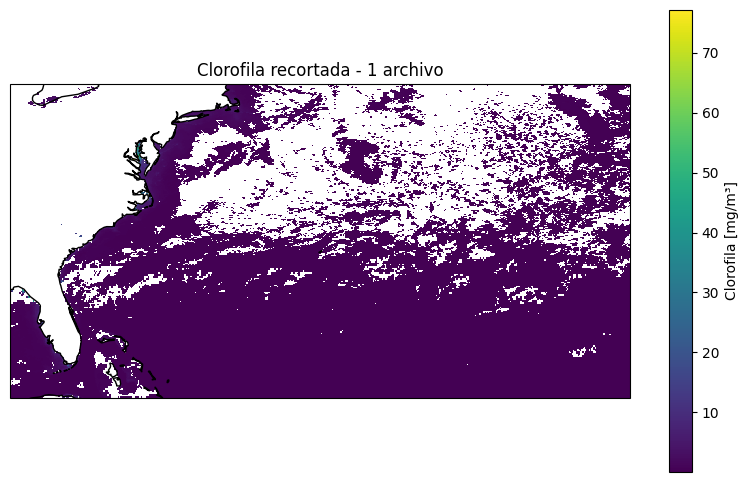

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Abrir el recorte
ds = xr.open_dataset("recorte_AQUA_MODIS.20130101_20130108.L3m.8D.CHL.chlor_a.4km.nc")

# Seleccionar la variable de clorofila
chl = ds['chlor_a']

# Graficar
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
chl.plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Clorofila [mg/m³]'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("Clorofila recortada - 1 archivo")
plt.show()

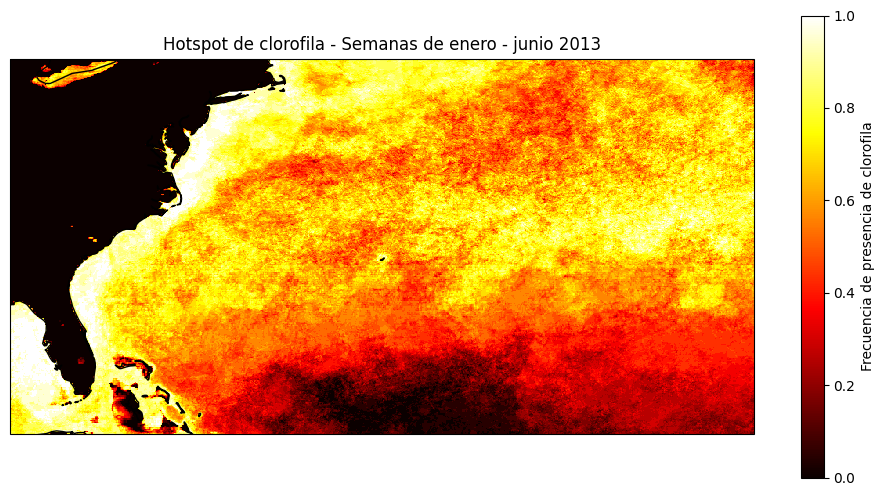

In [ ]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Archivos de recorte semanal
archivos = sorted(glob.glob("recorte_AQUA_MODIS.*8D.CHL*.nc"))

# Lista para guardar los DataArrays
chl_list = []

for f in archivos:
    ds = xr.open_dataset(f)
    chl = ds['chlor_a']
    # Crear máscara de presencia (> 0.1 mg/m³)
    chl_mask = (chl > 0.05).astype(int)
    chl_list.append(chl_mask)
    ds.close()

# Apilar todas las semanas en una dimensión nueva "week"
chl_stack = xr.concat(chl_list, dim='week')

# Calcular frecuencia de presencia (0-1)
hotmap = chl_stack.mean(dim='week')

# Graficar hotspot map
plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
im = hotmap.plot(ax=ax, cmap='hot', cbar_kwargs={'label':'Frecuencia de presencia de clorofila'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("Hotspot de clorofila - Semanas de enero - junio 2013")
plt.show()


# ATM Surface

---

In [ ]:
import xarray as xr
import pandas as pd
import glob
import os

# ----------------------------
# 1️⃣ Definir coordenadas de recorte
lon_min, lon_max = -84.6, -45
lat_min, lat_max = 23, 43

# Carpeta con archivos diarios ECCO 2013
archivos = sorted(glob.glob("ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-*.nc"))

# Listas para almacenar los recortes de cada variable
temp_list, hum_list, wind_list, pres_list = [], [], [], []

# ----------------------------
# 2️⃣ Procesar cada archivo diario
for f in archivos:
    print(f"Procesando {f} ...")
    ds = xr.open_dataset(f)

    # Recorte por lat/lon
    lat_coord = ds.coords['latitude']
    lon_coord = ds.coords['longitude']
    
    lat_slice = slice(lat_min, lat_max) if lat_coord[0] < lat_coord[-1] else slice(lat_max, lat_min)
    lon_slice = slice(lon_min, lon_max) if lon_coord[0] < lon_coord[-1] else slice(lon_max, lon_min)
    
    ds_rec = ds.sel(latitude=lat_slice, longitude=lon_slice)

    # Extraer fecha desde el nombre y reemplazar valor de time correctamente
    fecha_str = f.split("day_mean_")[1].split("_ECCO")[0]  # "2013-01-01"
    fecha = pd.to_datetime(fecha_str)
    
    # Reemplaza el valor de time como array de tamaño 1
    ds_rec = ds_rec.assign_coords(time=[fecha])

    # Guardar variables separadas en listas
    temp_list.append(ds_rec['EXFatemp'])
    hum_list.append(ds_rec['EXFaqh'])
    wind_list.append(ds_rec['EXFwspee'])
    pres_list.append(ds_rec['EXFpress'])

    ds.close()

# ----------------------------
# 3️⃣ Concatenar todas las fechas en un único DataArray por variable
temp_all = xr.concat(temp_list, dim='time')
hum_all  = xr.concat(hum_list, dim='time')
wind_all = xr.concat(wind_list, dim='time')
pres_all = xr.concat(pres_list, dim='time')

# ----------------------------
# 4️⃣ Definir semanas (cada 8 días) para promediar
semanas = pd.date_range(start=temp_all.time.values[0], end=temp_all.time.values[-1], freq='8D')

# ----------------------------
# 5️⃣ Promediar por semana y guardar archivos
output_dir = "semanal"
os.makedirs(output_dir, exist_ok=True)

for i in range(len(semanas)-1):
    start, end = semanas[i], semanas[i+1]-pd.Timedelta(days=1)
    
    # Seleccionar rango semanal
    temp_week = temp_all.sel(time=slice(start, end)).mean(dim='time')
    hum_week  = hum_all.sel(time=slice(start, end)).mean(dim='time')
    wind_week = wind_all.sel(time=slice(start, end)).mean(dim='time')
    pres_week = pres_all.sel(time=slice(start, end)).mean(dim='time')
    
    # Guardar cada variable en archivo netCDF separado
    temp_week.to_netcdf(f"{output_dir}/TEMP_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc")
    hum_week.to_netcdf(f"{output_dir}/HUM_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc")
    wind_week.to_netcdf(f"{output_dir}/WIND_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc")
    pres_week.to_netcdf(f"{output_dir}/PRES_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc")
    
    print(f"✅ Semana {start.date()} - {end.date()} guardada")

print("🎉 Todos los archivos semanales generados correctamente.")


Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-01_ECCO_V4r4_latlon_0p50deg.nc ...
Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-02_ECCO_V4r4_latlon_0p50deg.nc ...
Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-03_ECCO_V4r4_latlon_0p50deg.nc ...
Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-04_ECCO_V4r4_latlon_0p50deg.nc ...
Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-05_ECCO_V4r4_latlon_0p50deg.nc ...
Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-06_ECCO_V4r4_latlon_0p50deg.nc ...
Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-07_ECCO_V4r4_latlon_0p50deg.nc ...
Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-08_ECCO_V4r4_latlon_0p50deg.nc ...
Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-09_ECCO_V4r4_latlon_0p50deg.nc ...
Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-10_ECCO_V4r4_latlon_0p50deg.nc ...
Procesando ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-01-1

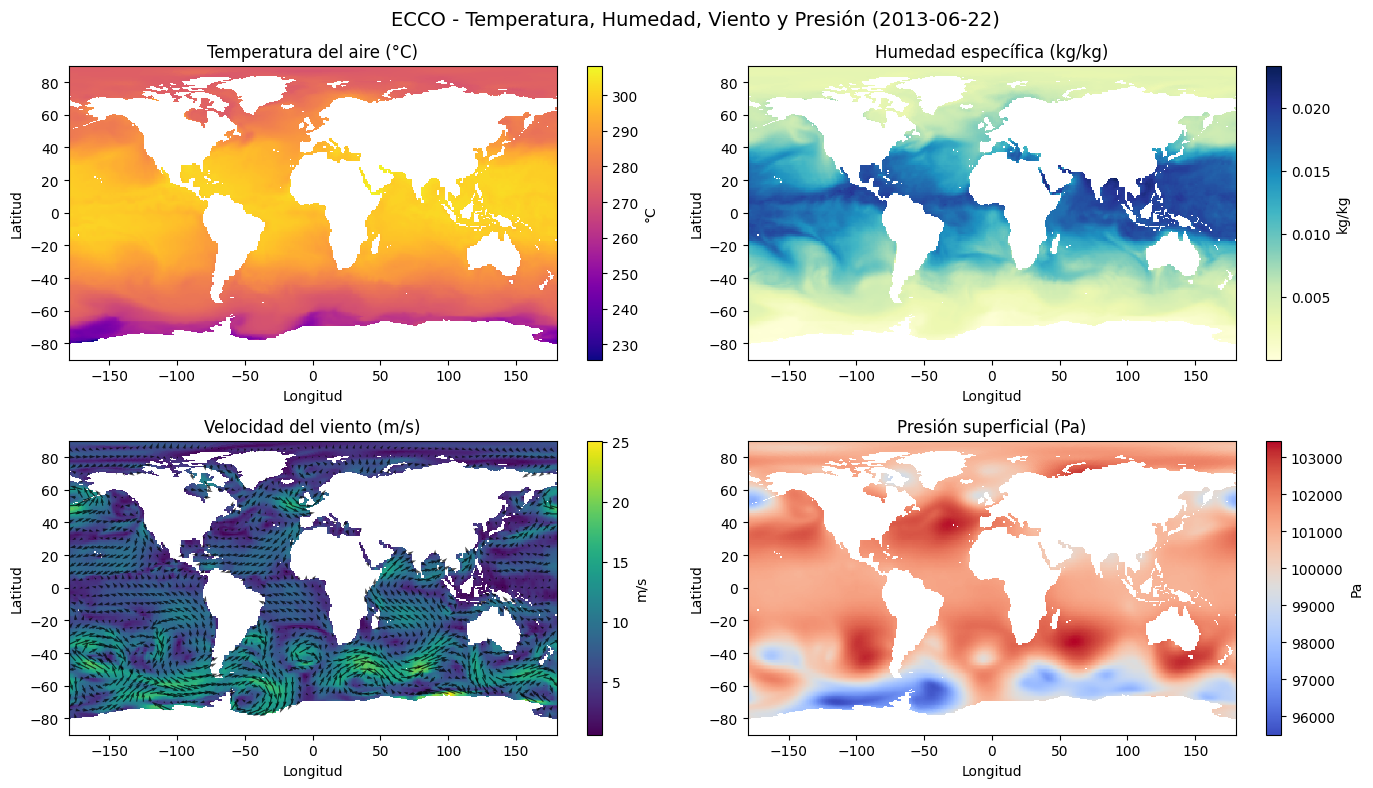

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# === 1️⃣ Cargar el archivo ===
ruta = "ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-06-22_ECCO_V4r4_latlon_0p50deg.nc"
ds = xr.open_dataset(ruta)

# === 2️⃣ Extraer variables ===
temp = ds["EXFatemp"].squeeze()      # Temperatura del aire (°C)
hum = ds["EXFaqh"].squeeze()         # Humedad específica (kg/kg)
wind_u = ds["EXFewind"].squeeze()    # Componente este del viento (m/s)
wind_v = ds["EXFnwind"].squeeze()    # Componente norte del viento (m/s)
wind_speed = ds["EXFwspee"].squeeze()# Velocidad del viento (m/s)
pres = ds["EXFpress"].squeeze()      # Presión superficial (Pa)

# === 3️⃣ Crear figura y ejes ===
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ---- Temperatura ----
im1 = axes[0, 0].pcolormesh(ds.longitude, ds.latitude, temp, shading="auto", cmap="plasma")
axes[0, 0].set_title("Temperatura del aire (°C)")
plt.colorbar(im1, ax=axes[0, 0], label="°C")

# ---- Humedad específica ----
im2 = axes[0, 1].pcolormesh(ds.longitude, ds.latitude, hum, shading="auto", cmap="YlGnBu")
axes[0, 1].set_title("Humedad específica (kg/kg)")
plt.colorbar(im2, ax=axes[0, 1], label="kg/kg")

# ---- Velocidad del viento ----
im3 = axes[1, 0].pcolormesh(ds.longitude, ds.latitude, wind_speed, shading="auto", cmap="viridis")
axes[1, 0].set_title("Velocidad del viento (m/s)")
plt.colorbar(im3, ax=axes[1, 0], label="m/s")

# Añadir flechas de viento
step = 10  # reduce densidad de flechas
axes[1, 0].quiver(
    ds.longitude[::step],
    ds.latitude[::step],
    wind_u[::step, ::step],
    wind_v[::step, ::step],
    scale=500,
    color='k',
    alpha=0.7
)

# ---- Presión superficial ----
im4 = axes[1, 1].pcolormesh(ds.longitude, ds.latitude, pres, shading="auto", cmap="coolwarm")
axes[1, 1].set_title("Presión superficial (Pa)")
plt.colorbar(im4, ax=axes[1, 1], label="Pa")

# === 4️⃣ Ajustar diseño y mostrar ===
for ax in axes.flat:
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")

plt.suptitle("ECCO - Temperatura, Humedad, Viento y Presión (2013-06-22)", fontsize=14)
plt.tight_layout()
plt.show()


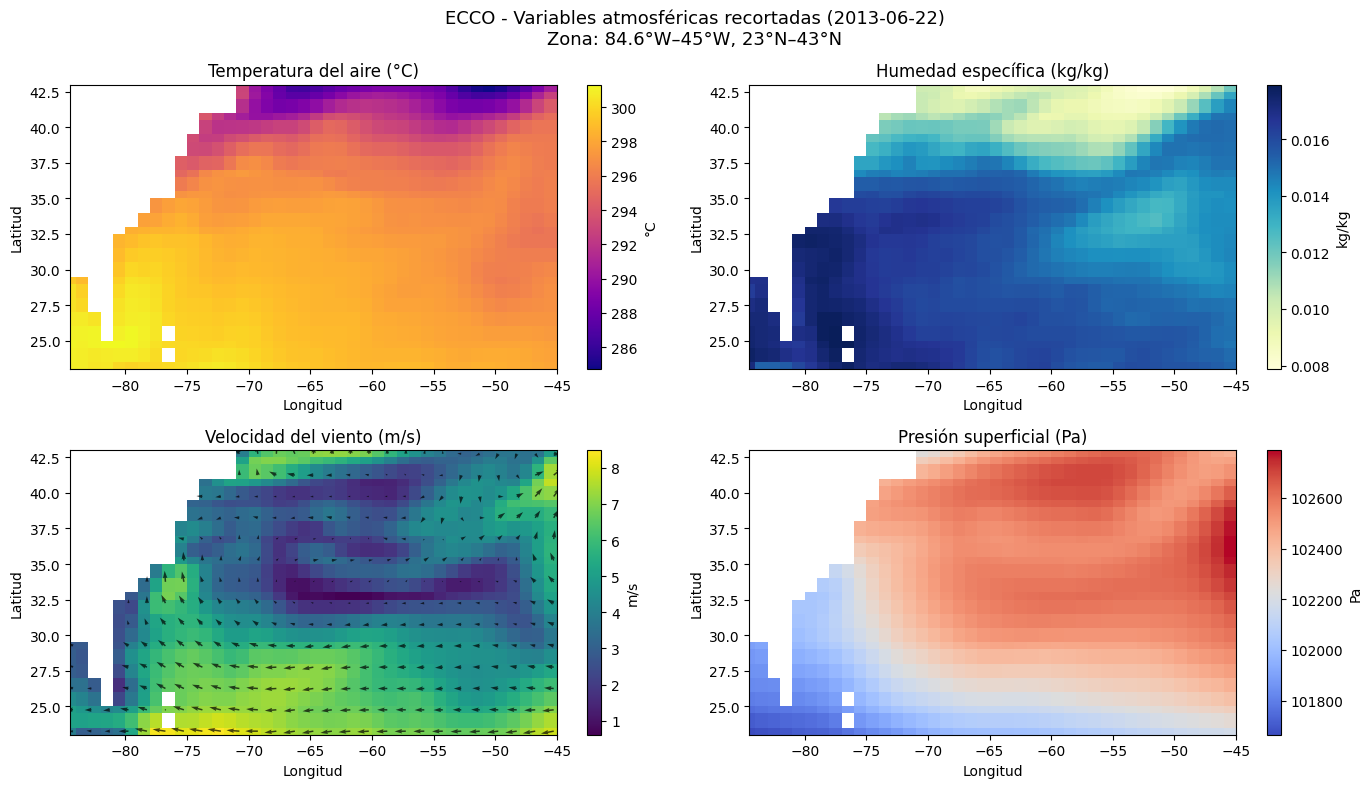

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# === 1️⃣ Cargar el archivo ===
ruta = "ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2013-06-22_ECCO_V4r4_latlon_0p50deg.nc"
ds = xr.open_dataset(ruta)

# === 2️⃣ Definir límites geográficos ===
# (°W se representan como negativos en longitud)
lon_min, lon_max = -84.6, -45.0
lat_min, lat_max = 23.0, 43.0

# === 3️⃣ Recortar dominio ===
ds_recorte = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

# === 4️⃣ Extraer variables ===
temp = ds_recorte["EXFatemp"].squeeze()      # Temperatura del aire (°C)
hum = ds_recorte["EXFaqh"].squeeze()         # Humedad específica (kg/kg)
wind_u = ds_recorte["EXFewind"].squeeze()    # Componente este del viento (m/s)
wind_v = ds_recorte["EXFnwind"].squeeze()    # Componente norte del viento (m/s)
wind_speed = ds_recorte["EXFwspee"].squeeze()# Velocidad del viento (m/s)
pres = ds_recorte["EXFpress"].squeeze()      # Presión superficial (Pa)

# === 5️⃣ Crear figura y ejes ===
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ---- Temperatura ----
im1 = axes[0, 0].pcolormesh(ds_recorte.longitude, ds_recorte.latitude, temp, shading="auto", cmap="plasma")
axes[0, 0].set_title("Temperatura del aire (°C)")
plt.colorbar(im1, ax=axes[0, 0], label="°C")

# ---- Humedad específica ----
im2 = axes[0, 1].pcolormesh(ds_recorte.longitude, ds_recorte.latitude, hum, shading="auto", cmap="YlGnBu")
axes[0, 1].set_title("Humedad específica (kg/kg)")
plt.colorbar(im2, ax=axes[0, 1], label="kg/kg")

# ---- Velocidad del viento ----
im3 = axes[1, 0].pcolormesh(ds_recorte.longitude, ds_recorte.latitude, wind_speed, shading="auto", cmap="viridis")
axes[1, 0].set_title("Velocidad del viento (m/s)")
plt.colorbar(im3, ax=axes[1, 0], label="m/s")

# Añadir flechas de viento
step = 3  # densidad de flechas (menor = más denso)
axes[1, 0].quiver(
    ds_recorte.longitude[::step],
    ds_recorte.latitude[::step],
    wind_u[::step, ::step],
    wind_v[::step, ::step],
    scale=300,
    color='k',
    alpha=0.7
)

# ---- Presión superficial ----
im4 = axes[1, 1].pcolormesh(ds_recorte.longitude, ds_recorte.latitude, pres, shading="auto", cmap="coolwarm")
axes[1, 1].set_title("Presión superficial (Pa)")
plt.colorbar(im4, ax=axes[1, 1], label="Pa")

# === 6️⃣ Ajustar diseño y mostrar ===
for ax in axes.flat:
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")

plt.suptitle("ECCO - Variables atmosféricas recortadas (2013-06-22)\nZona: 84.6°W–45°W, 23°N–43°N", fontsize=13)
plt.tight_layout()
plt.show()
